# TC 5033
## Deep Learning
## Transfer Learning

### **Members - Team 7**

* Eduardo Gabriel Arévalo Aguilar - A01793897
* David Andrés González Medina - A01794025
* Maricel Parra Osorio - A01793932
* Yeison Fernando Villamil Franco - A01793803

<br>

#### Activity 2c: Exploring Transfer Learning with CIFAR-10
<br>

- Objective:

    In this activity, you'll study the concept of Transfer Learning, a powerful technique to improve the performance of your models by leveraging pre-trained architectures. The provided notebook offers a complete solution using a specific pre-trained model on the CIFAR-10 dataset. Your task is to extend this by trying out two other pre-trained models.
    
- Instructions:

    This activity should be submitted in the same format as previous activities. Remember to include the names of all team members in a markdown cell at the beginning of the notebook. The grade obtained in this notebook will be averaged with that of Activity 2b, for the grade of Activity 2.    

    Study the Provided Code: The provided notebook has a complete Transfer Learning solution using a particular pre-trained model. Make sure you understand the flow of the code and the role of each component.

    Select Two Other Pre-trained Models: Choose two different pre-trained models available in PyTorch's model zoo.

    Apply Transfer Learning: Add cells to implement Transfer Learning using the two models you've chosen. Train these models on the CIFAR-10 dataset.

    Evaluation: After training, evaluate your models' performance. Compare the results with the provided solution and try to interpret why there might be differences.

    Documentation: In a markdown cell, summarize your findings. Include any challenges you faced, how you overcame them, and any interesting insights you gained from comparing the different pre-trained models.

- Note:

    Although the provided code serves as a guide, you're encouraged to implement the new solutions on your own. The goal is to reinforce your understanding of Transfer Learning and how to apply it effectively.




In [ ]:
# !pip install torch

In [ ]:
import mlutils
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as datasets
import torchvision.transforms as T
from torchvision import models

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
df = pd.read_csv('sample_data/california_housing_test.csv')

### Download data sets

In [ ]:
DATA_PATH = 'sample_data/cifar10-python' # Define where images are saved
NUM_TRAIN = 45000
MINIBATCH_SIZE = 64
transform_imagenet = T.Compose([
                T.Resize(224),
                T.ToTensor(),
                T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
            ])

transform_cifar = T.Compose([
                T.ToTensor(),
                T.Normalize([0.491, 0.482, 0.447], [0.247, 0.243, 0.261])
            ])

# Training set loader
cifar10_train = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                             transform=transform_imagenet)
train_loader = DataLoader(cifar10_train, batch_size=MINIBATCH_SIZE,
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

# Validation set loader
cifar10_val = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                           transform=transform_imagenet)
val_loader = DataLoader(cifar10_val, batch_size=MINIBATCH_SIZE,
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, len(cifar10_val))))

# Testing set loader
cifar10_test = datasets.CIFAR10(DATA_PATH, train=False, download=True,
                            transform=transform_imagenet)
test_loader = DataLoader(cifar10_test, batch_size=MINIBATCH_SIZE)

100%|██████████| 170498071/170498071 [00:04<00:00, 42151804.05it/s]


Extracting sample_data/cifar10-python/cifar-10-python.tar.gz to sample_data/cifar10-python
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Show the results

for i, (x, y) in enumerate(val_loader):
    print(i, x.shape, y.shape)

0 torch.Size([64, 3, 224, 224]) torch.Size([64])
1 torch.Size([64, 3, 224, 224]) torch.Size([64])
2 torch.Size([64, 3, 224, 224]) torch.Size([64])
3 torch.Size([64, 3, 224, 224]) torch.Size([64])
4 torch.Size([64, 3, 224, 224]) torch.Size([64])
5 torch.Size([64, 3, 224, 224]) torch.Size([64])
6 torch.Size([64, 3, 224, 224]) torch.Size([64])
7 torch.Size([64, 3, 224, 224]) torch.Size([64])
8 torch.Size([64, 3, 224, 224]) torch.Size([64])
9 torch.Size([64, 3, 224, 224]) torch.Size([64])
10 torch.Size([64, 3, 224, 224]) torch.Size([64])
11 torch.Size([64, 3, 224, 224]) torch.Size([64])
12 torch.Size([64, 3, 224, 224]) torch.Size([64])
13 torch.Size([64, 3, 224, 224]) torch.Size([64])
14 torch.Size([64, 3, 224, 224]) torch.Size([64])
15 torch.Size([64, 3, 224, 224]) torch.Size([64])
16 torch.Size([64, 3, 224, 224]) torch.Size([64])
17 torch.Size([64, 3, 224, 224]) torch.Size([64])
18 torch.Size([64, 3, 224, 224]) torch.Size([64])
19 torch.Size([64, 3, 224, 224]) torch.Size([64])
20 torch.S

### GPU used

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


### Show images

In the dataset, it is important to observe the quality of the images as well as the different classes that are being analyzed. This is why the `plot_figure` function allows you to randomly choose a value that will be a representation of the class with its respective pixels to be drawn in the box.

La imagen muestreada representa un: Ship


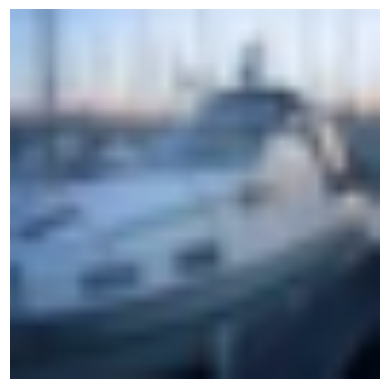

In [ ]:
classes = ['Plane', 'Car', 'Bird', 'Cat', 'Deer','Dog', 'Frog', 'Horse', 'Ship', 'Truck']

def plot_figure(image):
    plt.imshow(image.permute(1,2,0))
    plt.axis('off')
    plt.show()

rnd_sample_idx = np.random.randint(len(test_loader))
print(f'The sampled image respresents an/a: {classes[test_loader.dataset[rnd_sample_idx][1]]}')
image = test_loader.dataset[rnd_sample_idx][0]
image = (image - image.min()) / (image.max() -image.min() )
plot_figure(image)

### Calcular Accuracy

In [ ]:
def accuracy(model, loader):
    num_correct = 0
    num_total = 0
    model.eval()
    model = model.to(device=device)
    with torch.no_grad():
        for (xi, yi) in loader:
            xi = xi.to(device=device, dtype = torch.float32)
            yi = yi.to(device=device, dtype = torch.long)
            scores = model(xi) # mb_size, 10
            _, pred = scores.max(dim=1) #pred shape (mb_size )
            num_correct += (pred == yi).sum() # pred shape (mb_size), yi shape (mb_size, 1)
            num_total += pred.size(0)
        return float(num_correct)/num_total

### Prediction:

For the prediction, a function is developed that allows the model to be instantiated and using the `test` dataset to make its respective prediction, converting the arrays to `numpy` format on CPU to optimize the evaluation.

In [ ]:
def predict(model, test_loader, device):
    """
    Prediction using the trained model
    """

    # set model to evaluate model
    model.eval()

    y_true = torch.tensor([], dtype=torch.long, device=device)
    all_outputs = torch.tensor([], device=device)

    with torch.no_grad():
        for data in test_loader:
            inputs = [i.to(device) for i in data[:-1]]
            labels = data[-1].to(device)

            outputs = model(*inputs)
            y_true = torch.cat((y_true, labels), 0)
            all_outputs = torch.cat((all_outputs, outputs), 0)

    y_true = y_true.cpu().numpy()
    _, y_pred = torch.max(all_outputs, 1)
    y_pred = y_pred.cpu().numpy()

    return y_true, y_pred

### Confusion matrix

To construct the different confusion matrices (CM) for the 10 classes that we want to predict with the pre-trained models, a simple function has been developed that allows generating the CM graph with its respective classes.

In [ ]:
def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    Confusion matrix for multiclass problem
    """

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    class_names = ['Plane', 'Car', 'Bird', 'Cat', 'Deer','Dog', 'Frog', 'Horse', 'Ship', 'Truck']
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.xaxis.set_ticklabels(class_names, fontsize = 10)
    ax.yaxis.set_ticklabels(class_names, fontsize = 10)
    ax.set_ylabel('True label', fontsize=10)
    ax.set_xlabel('Predicted label', fontsize=10)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]))

    # Rotate the tick labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Creating text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    plt.title('Confusion Matrix', fontsize=15)
    return plt.show()

# Models

For this use case, the following pre-trained models will be used:

* ResNet (initially formulated in the notebook)
* RegNet
* GoogleNet

# **ResNet**

Due to the complexity of neural networks when training, the paper by Kaiming He, et al. (2015) shows a residual learning alternative for deeper networks. They reformulated the layers to residual functions with reference to the input layer. This showed that the residuals of the networks are easier to optimize and as a result have greater precision.

The neural network has 11689512 parameters which are loaded as a pre-trained convolutional model for specific tasks at the image level.

## Model

For all the cases that will be presented below, the loading of the model is done with the `models` instance, of `torchvision`.

In [ ]:
model_resnet18 = models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Exploring the model

Exploring the model by extracting the parameters allows us to understand the different components that each of the layers of the convolutional network contains. Here you can see the sizes, filters and activation functions.

From this point, It is very important to highlight the output layer, which has 1000 classes or output. This layer is the one that must be "removed" to be replaced by the one we want to adjust to predict the 10 CIFAR classes

In [ ]:
for i, w in enumerate(model_resnet18.parameters()):
    print(i, w.shape, w.requires_grad)

0 torch.Size([64, 3, 7, 7]) True
1 torch.Size([64]) True
2 torch.Size([64]) True
3 torch.Size([64, 64, 3, 3]) True
4 torch.Size([64]) True
5 torch.Size([64]) True
6 torch.Size([64, 64, 3, 3]) True
7 torch.Size([64]) True
8 torch.Size([64]) True
9 torch.Size([64, 64, 3, 3]) True
10 torch.Size([64]) True
11 torch.Size([64]) True
12 torch.Size([64, 64, 3, 3]) True
13 torch.Size([64]) True
14 torch.Size([64]) True
15 torch.Size([128, 64, 3, 3]) True
16 torch.Size([128]) True
17 torch.Size([128]) True
18 torch.Size([128, 128, 3, 3]) True
19 torch.Size([128]) True
20 torch.Size([128]) True
21 torch.Size([128, 64, 1, 1]) True
22 torch.Size([128]) True
23 torch.Size([128]) True
24 torch.Size([128, 128, 3, 3]) True
25 torch.Size([128]) True
26 torch.Size([128]) True
27 torch.Size([128, 128, 3, 3]) True
28 torch.Size([128]) True
29 torch.Size([128]) True
30 torch.Size([256, 128, 3, 3]) True
31 torch.Size([256]) True
32 torch.Size([256]) True
33 torch.Size([256, 256, 3, 3]) True
34 torch.Size([25

In [ ]:
model_resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Adjust to our model

* The `.children` instance returns the pre-trained model modules, which can be converted to a sequential network for later use.

* Additionally and as mentioned at the beginning, what we want is to use only the hidden capabilities and modify the last output layer for our use case. For this reason, in addition to the `.children` instance, the last layer of the form: `model.children())[:-1]` is eliminated

In [ ]:
len(list(model_resnet18.children()))

10

In [ ]:
model_aux = nn.Sequential(*list(model_resnet18.children()))
model_aux

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [ ]:
model_aux = nn.Sequential(*list(model_resnet18.children())[:-1])

In [ ]:
model_aux

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

To optimize training, declare the gradient requirement `False`


In [ ]:
for i, parameter in enumerate(model_aux.parameters()):
    parameter.requires_grad = False

In [ ]:
for i, parameter in enumerate(model_aux.parameters()):
    print(i, parameter.requires_grad)

0 False
1 False
2 False
3 False
4 False
5 False
6 False
7 False
8 False
9 False
10 False
11 False
12 False
13 False
14 False
15 False
16 False
17 False
18 False
19 False
20 False
21 False
22 False
23 False
24 False
25 False
26 False
27 False
28 False
29 False
30 False
31 False
32 False
33 False
34 False
35 False
36 False
37 False
38 False
39 False
40 False
41 False
42 False
43 False
44 False
45 False
46 False
47 False
48 False
49 False
50 False
51 False
52 False
53 False
54 False
55 False
56 False
57 False
58 False
59 False


## Training loop

In order to compare the models in the same way, the same number of neurons has been left for the hidden layers, the learning rate and the epochs. Only changing the values of the last layer that vary depending on each model

In [ ]:
def train(model, optimiser, epochs=100):
    model = model.to(device=device)
    for epoch in range(epochs):
        for i, (xi, yi) in enumerate(train_loader):
            model.train()
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            scores = model(xi)

            cost = F.cross_entropy(input= scores, target=yi)

            optimiser.zero_grad()
            cost.backward()
            optimiser.step()

        acc = accuracy(model, val_loader)
#         if epoch%5 == 0:
        print(f'Epoch: {epoch}, costo: {cost.item()}, accuracy: {acc},')
#         scheduler.step()

In [ ]:
hidden1 = 256
hidden = 256
lr = 5e-4
epochs = 3

model1 = nn.Sequential(model_aux,
                       nn.Flatten(),
                       nn.Linear(in_features=512, out_features= 10, bias= True))
optimiser = torch.optim.Adam(model1.parameters(), lr=lr, betas=(0.9, 0.999))

In [ ]:
train(model1, optimiser, epochs)

Epoch: 0, costo: 1.085590124130249, accuracy: 0.7756,
Epoch: 1, costo: 1.2678829431533813, accuracy: 0.792,
Epoch: 2, costo: 0.7226329445838928, accuracy: 0.799,


In [ ]:
print(f'The value of the accuracy for the ResNet model is: {accuracy(model1, test_loader)}')

The value of the accuracy for the ResNet model is: 0.8009


In [ ]:
y_true, y_pred = predict(model1, test_loader, device)

Normalized confusion matrix


<ipython-input-132-92979b6ccc67>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(class_names, fontsize = 10)
<ipython-input-132-92979b6ccc67>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.yaxis.set_ticklabels(class_names, fontsize = 10)


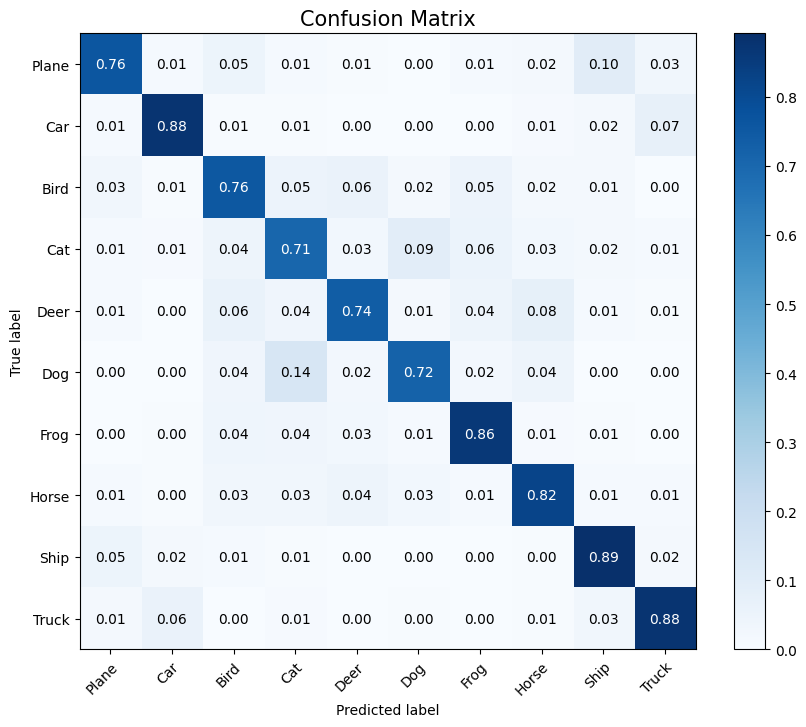

In [ ]:
plot_confusion_matrix(y_true, y_pred,normalize=True)

### **ResNet Conclusions**

From the results for the `ResNet` model it can be concluded:

* The overall accuracy for the tuning performed with the model is 80.09%
* In the case of predictions, it is observed that the class with the lowest value of true positives, which predicted correctly, is 71% corresponding to cats.
* In the case of the class with the best prediction and accuracy, it corresponds to ship with 89%
* With a greater number of epochs it is possible to have an improvement in accuracy. However, at the level of true positives it is observed that there is good performance.

# **RegNet**

The work presented by Radosavovic, Ilija, et al (2020) shows a way to parameterize populations of neural networks jointly and not individually. The main idea is the following: The widths and depths of neural networks can be explained precisely with linear functions. Providing simple and fast networking.

The model has 4344144 parameters with an output layer of 1000 outputs

## Model

In [ ]:
model_retneg = models.regnet_y_400mf(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RegNet_Y_400MF_Weights.IMAGENET1K_V1`. You can also use `weights=RegNet_Y_400MF_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/regnet_y_400mf-c65dace8.pth" to /root/.cache/torch/hub/checkpoints/regnet_y_400mf-c65dace8.pth
100%|██████████| 16.8M/16.8M [00:00<00:00, 62.0MB/s]


## Exploring the model

In [ ]:
for i, w in enumerate(model_retneg.parameters()):
    print(i, w.shape, w.requires_grad)

0 torch.Size([32, 3, 3, 3]) True
1 torch.Size([32]) True
2 torch.Size([32]) True
3 torch.Size([48, 32, 1, 1]) True
4 torch.Size([48]) True
5 torch.Size([48]) True
6 torch.Size([48, 32, 1, 1]) True
7 torch.Size([48]) True
8 torch.Size([48]) True
9 torch.Size([48, 8, 3, 3]) True
10 torch.Size([48]) True
11 torch.Size([48]) True
12 torch.Size([8, 48, 1, 1]) True
13 torch.Size([8]) True
14 torch.Size([48, 8, 1, 1]) True
15 torch.Size([48]) True
16 torch.Size([48, 48, 1, 1]) True
17 torch.Size([48]) True
18 torch.Size([48]) True
19 torch.Size([104, 48, 1, 1]) True
20 torch.Size([104]) True
21 torch.Size([104]) True
22 torch.Size([104, 48, 1, 1]) True
23 torch.Size([104]) True
24 torch.Size([104]) True
25 torch.Size([104, 8, 3, 3]) True
26 torch.Size([104]) True
27 torch.Size([104]) True
28 torch.Size([12, 104, 1, 1]) True
29 torch.Size([12]) True
30 torch.Size([104, 12, 1, 1]) True
31 torch.Size([104]) True
32 torch.Size([104, 104, 1, 1]) True
33 torch.Size([104]) True
34 torch.Size([104]) 

In [ ]:
model_retneg

RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 48, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=6, bias=False)
            

## Training

In [ ]:
model_retneg_aux = nn.Sequential(*list(model_retneg.children())[:-1])

In [ ]:
model_retneg_aux

Sequential(
  (0): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (1): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 48, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=6, bias=False)
            (1): Batch

In [ ]:
model_retneg

RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 48, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=6, bias=False)
            

In [ ]:
for i, parameter in enumerate(model_retneg_aux.parameters()):
    parameter.requires_grad = False

In [ ]:
hidden1 = 256
hidden = 256
lr = 5e-4
epochs = 3

model_2 = nn.Sequential(model_retneg_aux,
                       nn.Flatten(),
                       nn.Linear(in_features=440, out_features= 10, bias= True))
optimiser = torch.optim.Adam(model_2.parameters(), lr=lr, betas=(0.9, 0.999))

In [ ]:
train(model_2, optimiser, epochs)

Epoch: 0, costo: 0.6054548025131226, accuracy: 0.7662,
Epoch: 1, costo: 1.1858888864517212, accuracy: 0.7906,
Epoch: 2, costo: 0.5759842395782471, accuracy: 0.7996,


In [ ]:
print(f'The value of the accuracy for the RegNet model is: {accuracy(model_2, test_loader)}')

The value of the accuracy for the RegNet model is: 0.797


Normalized confusion matrix


<ipython-input-132-92979b6ccc67>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(class_names, fontsize = 10)
<ipython-input-132-92979b6ccc67>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.yaxis.set_ticklabels(class_names, fontsize = 10)


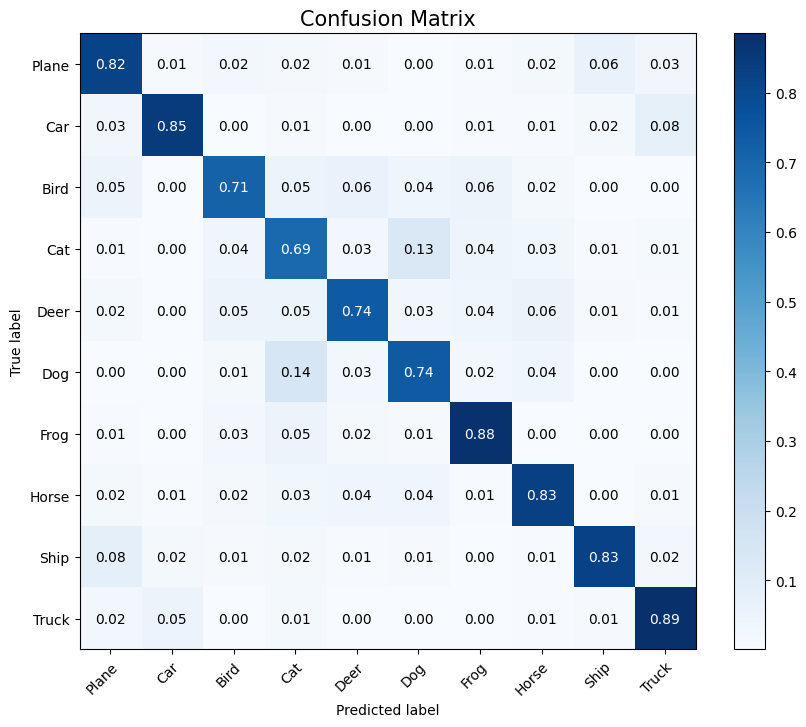

In [ ]:
y_true_regnet, y_pred_regnet = predict(model_2, test_loader, device)
plot_confusion_matrix(y_true_regnet, y_pred_regnet,normalize=True)

### **RegNet Conclusions**

From the results for the `RegNet` model it can be concluded:

* The overall accuracy for the tuning performed with the model is 79.97%
* In the case of predictions, it is observed that the class with the lowest value of true positives, which predicted correctly, is 69% corresponding to cat.
* In the case of the class with the best prediction and accuracy, it corresponds to truck with 89%
* With a greater number of epochs it is possible to have an improvement in accuracy. However, at the level of true positives it is observed that there is good performance.

# **GoogLeNet**

The model was one of the convolutional neural network models developed by Christian Szegedy, et al (2015) where they proposed a neural network architecture which established a new state of the art during the 2014 ImageNet challenge. The Hebbian principle and multiscale processing were the firsts for its development.

The model has 6624904 parameters

## Model

In [ ]:
model_gnet = models.googlenet(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 145MB/s]


## Exploring the model

In [ ]:
for i, w in enumerate(model_gnet.parameters()):
    print(i, w.shape, w.requires_grad)

0 torch.Size([64, 3, 7, 7]) True
1 torch.Size([64]) True
2 torch.Size([64]) True
3 torch.Size([64, 64, 1, 1]) True
4 torch.Size([64]) True
5 torch.Size([64]) True
6 torch.Size([192, 64, 3, 3]) True
7 torch.Size([192]) True
8 torch.Size([192]) True
9 torch.Size([64, 192, 1, 1]) True
10 torch.Size([64]) True
11 torch.Size([64]) True
12 torch.Size([96, 192, 1, 1]) True
13 torch.Size([96]) True
14 torch.Size([96]) True
15 torch.Size([128, 96, 3, 3]) True
16 torch.Size([128]) True
17 torch.Size([128]) True
18 torch.Size([16, 192, 1, 1]) True
19 torch.Size([16]) True
20 torch.Size([16]) True
21 torch.Size([32, 16, 3, 3]) True
22 torch.Size([32]) True
23 torch.Size([32]) True
24 torch.Size([32, 192, 1, 1]) True
25 torch.Size([32]) True
26 torch.Size([32]) True
27 torch.Size([128, 256, 1, 1]) True
28 torch.Size([128]) True
29 torch.Size([128]) True
30 torch.Size([128, 256, 1, 1]) True
31 torch.Size([128]) True
32 torch.Size([128]) True
33 torch.Size([192, 128, 3, 3]) True
34 torch.Size([192]) 

In [ ]:
model_gnet

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

## Training

In [ ]:
model_gnet_aux = nn.Sequential(*list(model_gnet.children())[:-1])

In [ ]:
for i, parameter in enumerate(model_gnet_aux.parameters()):
    parameter.requires_grad = False

In [ ]:
hidden1 = 256
hidden = 256
lr = 5e-4
epochs = 3

model_3 = nn.Sequential(model_gnet_aux,
                       nn.Flatten(),
                       nn.Linear(in_features=1024, out_features= 10, bias= True))
optimiser = torch.optim.Adam(model_3.parameters(), lr=lr, betas=(0.9, 0.999))

In [ ]:
train(model_3, optimiser, epochs)

Epoch: 0, costo: 0.9372701048851013, accuracy: 0.7696,
Epoch: 1, costo: 1.1321640014648438, accuracy: 0.79,
Epoch: 2, costo: 0.6594190001487732, accuracy: 0.7992,


In [ ]:
print(f'The value of the accuracy for the GoogleNet model is: {accuracy(model_3, test_loader)}')

The value of the accuracy for the GoogleNet model is: 0.7881


Normalized confusion matrix


<ipython-input-132-92979b6ccc67>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(class_names, fontsize = 10)
<ipython-input-132-92979b6ccc67>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.yaxis.set_ticklabels(class_names, fontsize = 10)


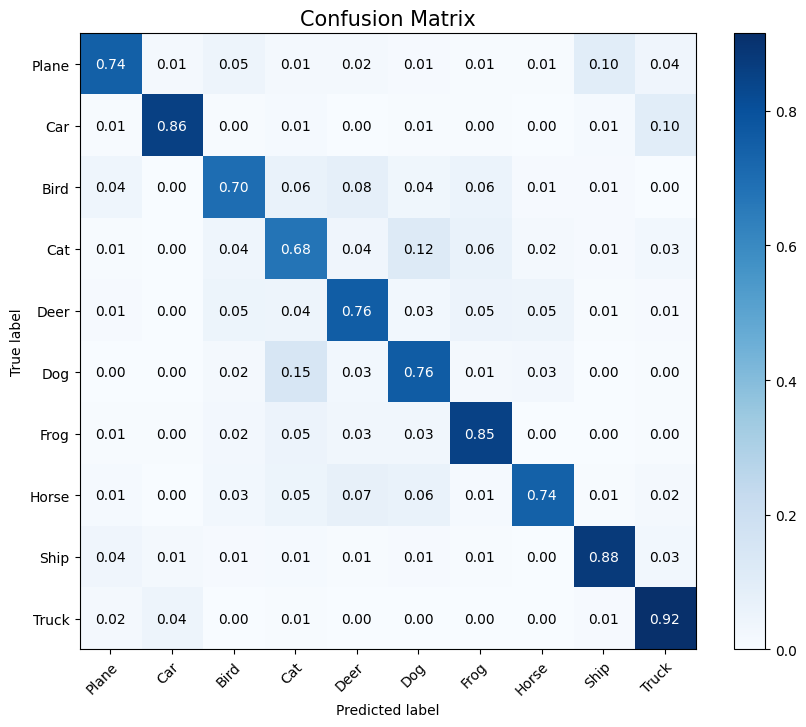

In [ ]:
y_true_gnet, y_pred_gnet = predict(model_3, test_loader, device)
plot_confusion_matrix(y_true_gnet, y_pred_gnet,normalize=True)

### **GoogLeNet Conclusions**

From the results for the `GoogLeNet` model it can be concluded:

* The overall accuracy for the tuning performed with the model is 78.81%
* In the case of predictions, it is observed that the class with the lowest value of true positives, which predicted correctly, is 68% corresponding to cat.
* In the case of the class with the best prediction and accuracy, it corresponds to truck with 92%
* With a greater number of epochs it is possible to have an improvement in accuracy. However, at the level of true positives it is observed that there is good performance.

# **Conclusions**

* During the different tuned models, it is observed that although the different ones do not exceed a difference of 2% accuracy for all cases, the `ResNet` model has a better accuracy with a value of 80.09%. For this case, it is important to consider that the `ResNet` model has been the most implemented and that it has special conditions which have generated better results for different tests in the literature.
* Although the `GoogLeNet` model has the lowest accuracy of the three tuned models, with a value of 78.81%, it is observed that for the `Truck` class it obtains a percentage of true positives of 92%, being the highest of the three. This shows that in transfer learning process, within the trained patterns of each layer and also considering the number of epochs of 3, it tends to predict this specific class in a better way.
* For the `Truck` class, the three models have the highest percentages of true positives (in the case of `RegNet` it is the second. However, due to the shapes of the images, we can declare that a `Ship` and a ` Truck` considering the quality of the images tend to be similar). This shows the shapes that the models have in their different layers and that can more easily match these types of images.
* In the case of the lowest true positive rate, all three models agreed in the same class, with the cat being the least favored.
* It is important to consider a greater number of epochs (and train on GPUs) to see if the quality of the predictions improves. The number of epochs is set equal to 3 for all cases in order to have repeatability and be comparable.
* In addition to what has been observed, it is also important to be able to go into depth of each model and understand the components to establish how good they can be for each of the cases that you want to evaluate.
* In general terms for such short training, the models tend to perform well and the high prediction capacity is evident considering the quality of the images.
* If we look in detail at the classes in the confusion matrix, we see that for the classes cat, deer and dog there is a similarity since the models tend to put false positives between them. This is possibly because the quality of the images shows a similarity between this type of classes.

### **True positive percentage**

| Class | ResNet | RegNet | GoogLeNet  |
|--------------|--------------|--------------|--------------|
| Plane | 76% | 82% | 74% |
| Car | 88% | 85% | 86% |
| Bird | 76% | 71% | 70% |
| Cat | 71% | 69% | 68% |
| Deer | 74% | 74% | 76% |
| Dog | 72% | 74% | 76% |
| Frog | 86% | 88% | 85% |
| Horse | 82% | 83% | 74% |
| Ship | 89% | 83% | 88% |
| Truck | 88% | 89% | 92% |

# **References**

* He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep residual learning for image recognition. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 770-778).
* Radosavovic, I., Kosaraju, R. P., Girshick, R., He, K., & Dollár, P. (2020). Designing network design spaces. In Proceedings of the IEEE/CVF conference on computer vision and pattern recognition (pp. 10428-10436).
* Szegedy, C., Liu, W., Jia, Y., Sermanet, P., Reed, S., Anguelov, D., ... & Rabinovich, A. (2015). Going deeper with convolutions. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 1-9).